In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
cd /content/drive/MyDrive/gammaAE/Simulation_study

/content/drive/MyDrive/gammaAE/Simulation_study


Consider a model

\begin{align}
    Z & \sim p(z)  = 
    t_q(\mathbf{0}_q, D, \nu), \\[2mm]
    X_\theta|Z & \sim p_\theta(x|z) = 
    t_p\left(
        f_\theta(z), 
        \frac{1 + \nu^{-1} z^\intercal D^{-1} z}{1 + \nu^{-1} q} \Lambda, \nu+q 
    \right). 
\end{align}

If $f_\theta(z) = Az + b$, then

\begin{align}
    \begin{bmatrix}
        X_\theta \\ Z 
    \end{bmatrix} 
    & \sim
    t_{p+q} \left(
        \begin{bmatrix}
            b \\ \mathbf{0}_q
        \end{bmatrix}, 
        \begin{bmatrix}
            ADA^\intercal + \Lambda & AD \\
            DA^\intercal             & D
        \end{bmatrix}, 
        \nu
    \right), \\[5mm]
    X_\theta
    & \sim 
    t_p \left(
        b, ADA^\intercal + \Lambda, \nu
    \right)
    \\
    Z|X_\theta 
    & \sim t_q \left(
        DA^\intercal \left(
            ADA^\intercal + \Lambda
        \right)^{-1}(x - b), 
        \frac{\nu + (x-b)^\intercal \left(
            ADA^\intercal + \Lambda
        \right)^{-1} (x-b)}{\nu+p}\left(
            D - DA^\intercal \left(
                ADA^\intercal + \Lambda
            \right)^{-1} AD
        \right), 
        \nu+p
    \right)
\end{align}

If $D = I_q$ and $\Lambda = \sigma^2 I_p$, then 

\begin{align}
    \begin{bmatrix}
        X_\theta \\ Z 
    \end{bmatrix} 
    & \sim
    t_{p+q} \left(
        \begin{bmatrix}
            b \\ \mathbf{0}_q
        \end{bmatrix}, 
        \begin{bmatrix}
            AA^\intercal + \sigma^2 I_p & A \\
            A^\intercal             & I_q
        \end{bmatrix}, 
        \nu
    \right), \\[5mm]
    X_\theta
    & \sim 
    t_p \left(
        b, AA^\intercal + \sigma^2 I_p, \nu
    \right)
    \\
    Z|X_\theta 
    & \sim t_q \left(
        A^\intercal \left(
            AA^\intercal + \sigma^2 I_p
        \right)^{-1}(x - b), 
        \frac{\nu + (x-b)^\intercal \left(
            AA^\intercal + \sigma^2 I_p
        \right)^{-1} (x-b)}{\nu+p}\left(
            I_q - A^\intercal \left(
                AA^\intercal + \sigma^2 I_p
            \right)^{-1} A
        \right), 
        \nu+p
    \right)
\end{align}

In [47]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from simul_util import make_reproducibility, sampling, simulation, MYTensorDataset 

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device(f'cuda:0' if USE_CUDA else "cpu")

p_dim = 2
q_dim = 1
nu = 5
epochs = 100
num_layers = 32
recon_sigma = 3

make_reproducibility(5000)

A = torch.randn(p_dim,q_dim)
b = torch.randn(p_dim)

t_sample = simulation(
    DEVICE, p_dim = p_dim, SEED = 1500, 
    K = 1, N_list = [5000], 
    mu_list = [b], 
    var_list = [recon_sigma * torch.eye(p_dim) + A @ A.T], 
    nu_list = [5]
)

simulation_trainset = MYTensorDataset(t_sample)

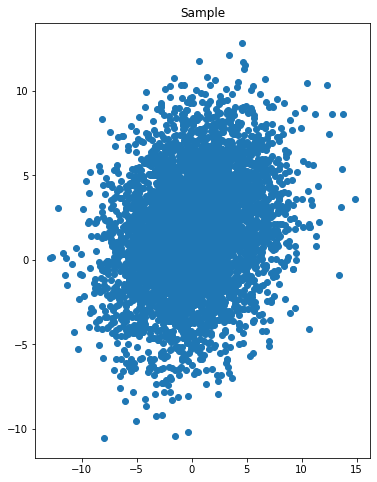

In [48]:
import matplotlib.pyplot as plt
from simul_visualize import visualize_2D, visualize_3D, total_visualize_2D, total_visualize_3D

# visualize_3D(t_sample).show()
visualize_2D(t_sample).show()

In [49]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from simul_loss import log_t_normalizing_const, gamma_regularizer
from simul_model import Encoder, Decoder, gammaAE
from simul_shallow import Shallow_Encoder, Shallow_Decoder, Shallow_gammaAE

gAE = Shallow_gammaAE(simulation_trainset, p_dim, q_dim, nu, DEVICE, num_layers = num_layers, recon_sigma = recon_sigma)
VAE = Shallow_gammaAE(simulation_trainset, p_dim, q_dim, 0 , DEVICE, num_layers = num_layers, recon_sigma = recon_sigma)

epoch_tqdm = tqdm(range(0, epochs))
for epoch in epoch_tqdm : 
    # print(f'\nEpoch {epoch}')
    gAE.train(epoch)
    VAE.train(epoch)

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


In [50]:
print(gAE.decoder.fc.weight)
print(A)

print(gAE.decoder.fc.bias)
print(b)

print(gAE.encoder.latent_mu.weight)
print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma * torch.eye(p_dim)))

print(gAE.encoder.latent_mu.bias)
print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma * torch.eye(p_dim)) @ b)



Parameter containing:
tensor([[-1.9919],
        [-1.0982]], device='cuda:0', requires_grad=True)
tensor([[1.2260],
        [0.7785]])
Parameter containing:
tensor([-0.1764,  1.3868], device='cuda:0', requires_grad=True)
tensor([0.1723, 1.6410])
Parameter containing:
tensor([[-0.3671, -0.2021]], device='cuda:0', requires_grad=True)
tensor([[0.2400, 0.1524]])
Parameter containing:
tensor([0.2158], device='cuda:0', requires_grad=True)
tensor([0.2914])


In [51]:
MVT_prior = sampling(1000, torch.zeros(q_dim), torch.eye(q_dim), nu, DEVICE)
MVN_prior = sampling(1000, torch.zeros(q_dim), torch.eye(q_dim), 0, DEVICE)

gAE_reconstruction = gAE.decoder(gAE.encoder(t_sample)[0]).detach().cpu().numpy()
VAE_reconstruction = VAE.decoder(VAE.encoder(t_sample)[0]).detach().cpu().numpy()

gAE_sample = gAE.decoder(MVT_prior).detach().cpu().numpy()
VAE_sample = VAE.decoder(MVN_prior).detach().cpu().numpy()

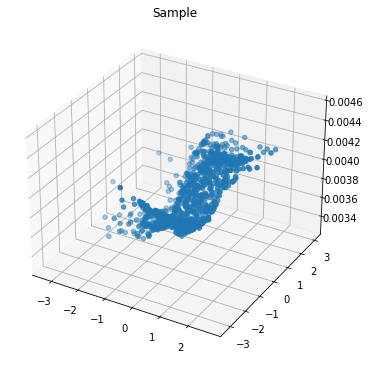

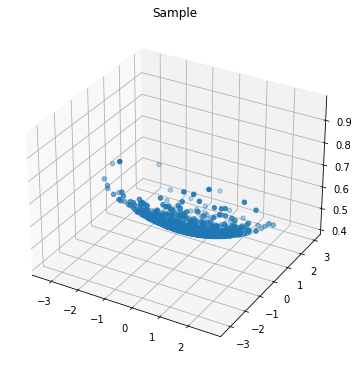

In [52]:
x_sample = sampling(1000, torch.zeros(p_dim), torch.eye(p_dim), nu, DEVICE)
var_recon = torch.exp(gAE.encoder.latent_var(x_sample))


def true_var(x, p_dim, q_dim, A, b, nu, recon_sigma) : 
    term1 = (nu + (x - b).T @ torch.linalg.inv(A @ A.T + recon_sigma * torch.eye(p_dim)) @ (x - b)) / (nu + p_dim)
    term2 = torch.eye(q_dim) - A.T @ torch.linalg.inv(A @ A.T + recon_sigma * torch.eye(p_dim)) @ A
    return term1 * term2

true_var_list = [
    true_var(x.cpu(), p_dim, q_dim, A, b, nu, recon_sigma) for x in x_sample
]
torch.as_tensor(true_var_list).unsqueeze(1).shape
torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1)

visualize_3D(torch.cat([x_sample, var_recon], axis = 1).detach()).show()

visualize_3D(torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1).detach()).show()


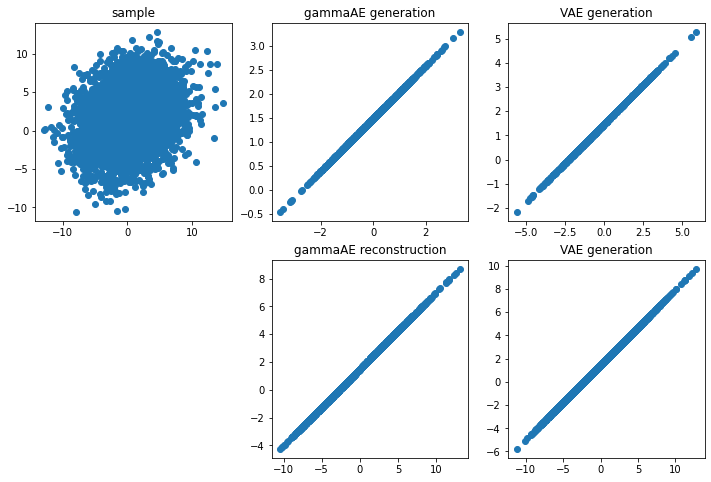

In [53]:
total_visualize_2D(t_sample, gAE_reconstruction, gAE_sample, 
                   VAE_reconstruction, VAE_sample).show()
# total_visualize_3D(t_sample, gAE_reconstruction, gAE_sample, 
#                    VAE_reconstruction, VAE_sample).show()